In [1]:
 ##THE LYBRARIES USED IN THIS NOTEBOOK

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import seaborn as sns




### We load the file into pandas

In [2]:
#We will retrieve the Wikipedia Articles Dataset
dataset = 'https://bit.ly/2HuS1c0'
people_wiki_df = pd.read_csv(dataset)
#Lets see what we have in the dataset
people_wiki_df.head(3)



,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...


### Get the word counts for Clinton article

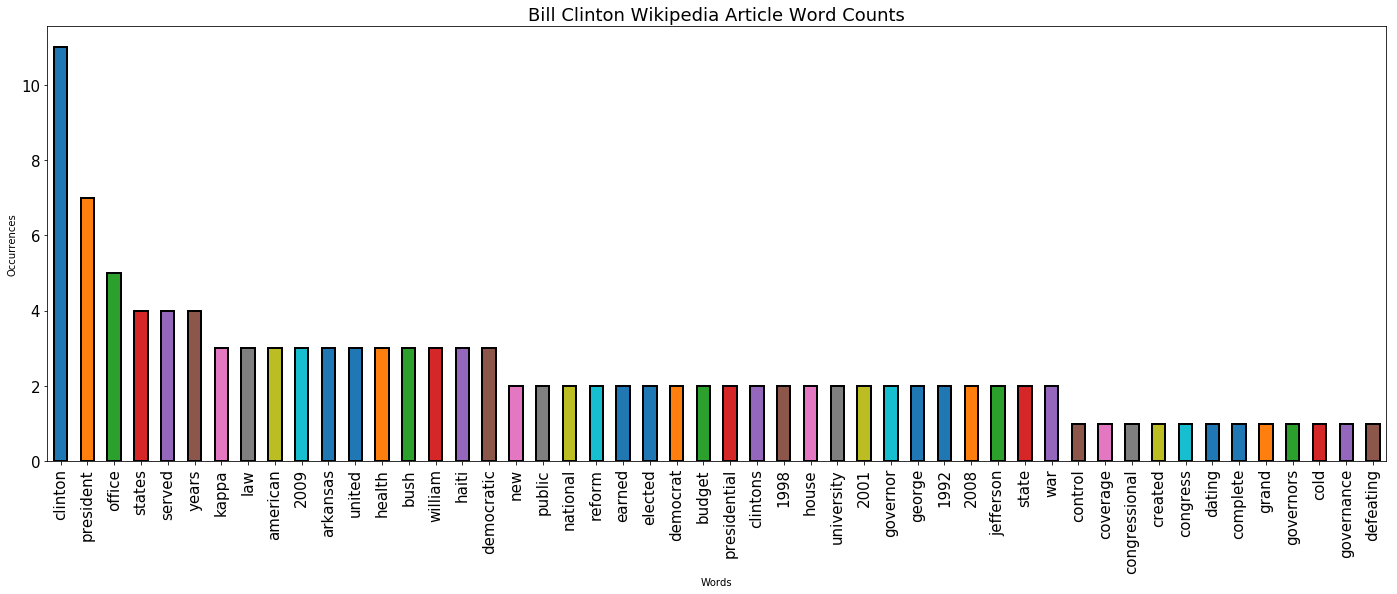

In [3]:
#We get the text column from Bill
bill_clinton_text = people_wiki_df.loc[people_wiki_df['name']=='Bill Clinton', 'text'].tolist()
counter = CountVectorizer(stop_words='english')
count_matrix =counter.fit_transform(bill_clinton_text)
features = counter.get_feature_names()
#Create a series from the sparse matrix
clinton_counter = pd.Series(count_matrix.toarray().flatten(), 
              index = features).sort_values(ascending=False)
#We are gonna plot the most 50 frequent words in Bill's article, without taking under consideration  the stopwords.
bar_graph = clinton_counter[:50].plot(kind='bar', figsize=(24,8), alpha=1, fontsize=15, rot=90,edgecolor='black', linewidth=2,
            title='Bill Clinton Wikipedia Article Word Counts')
bar_graph.set_xlabel('Words')
bar_graph.set_ylabel('Occurrences')
bar_graph.title.set_size(18)



### Compute TF-IDF for the corpus

#### What is TF-IDF?
- It's used in document retrieval and text mining
- TDF.-IDF concept  can be used to create a profile of an article
- It stands for term frecuency times inverse document frecuency $TF_{IDF} = TF*IDF$. When we multiply this two together. We get a weight. And that weight is assigned to a term. 
- Term frecuency(TF): Number of ocurrences of the term in the document. When we talk about term frecuency we could mean how ofter does  the term , lets say 'car accident,' appear on the article. But we also could mean how often  the tag 'car accident' get applied to the article. 
- Inverse Document Frecuency (IDF): How few documents contains this term $ \rightarrow log \frac{ \#documents}{ \# documents\quad with\quad  term} $ Intuitively refers how rare for a document to have this term or for a tag to be applied to the article. $\rightarrow$ the higher the number of documents that have this term , the lower the IDF value is. We dont care much about a term if appears everywher, but we care a lot about a term if it is rare. 

$$W_{t_d} =   (1 + log   tf _{t_d}) log( \frac{N}{df_t}) $$
In other words, tf-idft,d assigns to term $t$ a weight in document $d$ that is
1. highest when $t$ occurs many times within a small number of documents 
2. lower when the term occurs fewer times in a document,or occurs in many documents 
3. lowest when the term occurs in virtually all documents.

#### Final ranking of documents for a query
 $$ Score(q,d) =\sum_ {t\in q\cap d}  tf.idf_{t,d}   $$
 
 Where $q \: and \:   d$ are two different documents .The score of a document $d$ is the sum, over all query terms, of the number of times each of the query terms occurs in  $d$. We can refine this idea so that we add up not the number of occurrences of each query term $t$ in  $d$, but instead the tf-idf weight of each term in $d$. In this exact case we usee knn for clustering ,this is one apporach you could use we only the $tdf-idf$ matix, there is another approach as cosine similarity to make queries. If you would like to read more about it check the references, particularly the one called ' Scoring, term weighting and the vector space model'.

#### Pros
-  Automatic demotion of stopword-
-  Promotes core words over incidental ones.

#### Cons
- If core term doens't appear much.
- Poor searches (Better techniques like search completion and query completion).
. it doenst recognize significance in documents (Titles, headings).
- Phrases and n-grams (Scikit Tfidfvectorizer has an option to take under consideration this scenario).

#### Variants on TF-IDF
- 0/1 Boolean frecuencies (occurs above threshold).
- Logarithmic frecuencies (tf +1).
- Normalized frecuencies (divide by document length).

Text(0,0.5,'TF-IDF')

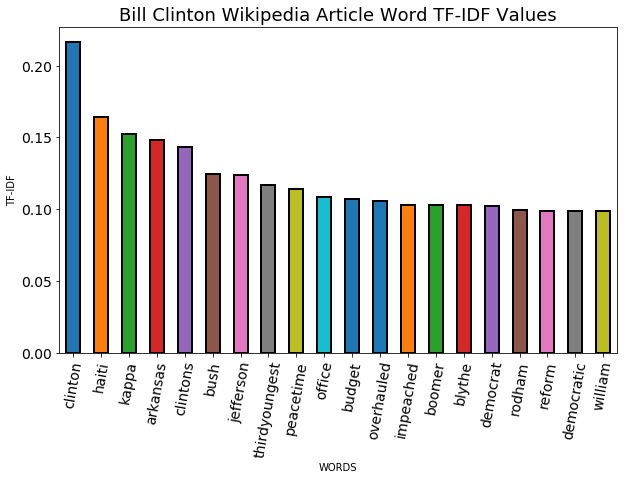

In [4]:
name = 'Bill Clinton'
#TfidfVectorizer: Converts a collection of raw documents to a matrix of TF-IDF features.
#min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
#max_df: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold.
#Apply this vectorizer to the full dataset to create normalized vectors
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, sublinear_tf=True, use_idf =True, stop_words = 'english')
#tfidf_vectorizer.fit: Learn vocabulary and idf from training set.
tfidf_matrix = tfidf_vectorizer.fit_transform(people_wiki_df.text.values)
#tfidf_vectorizer.get_feature_names(): Array mapping from feature integer indices to feature name
features = tfidf_vectorizer.get_feature_names()
#tfidf_vectorizer.get_feature_names(): Array mapping from feature integer indices to feature name
#Get the row that belongs to Bill Clinton
row = people_wiki_df[people_wiki_df.name==name].index.tolist()[0]
#Create a series from the sparse matrix
clinton_matrix = pd.Series(tfidf_matrix.getrow(row).toarray().flatten(),index = features).sort_values(ascending=False)
tf_idf_plot = clinton_matrix[:20].plot(kind='bar', title='Bill Clinton Wikipedia Article Word TF-IDF Values',
            figsize=(10,6), alpha=1, fontsize=14, rot=80,edgecolor='black', linewidth=2 )
tf_idf_plot.title.set_size(18)
tf_idf_plot.set_xlabel('WORDS')
tf_idf_plot.set_ylabel('TF-IDF')



### K NEAREST NEIGHBOURS

The general idea is you have a bunch of training points and each of these points has a bunch of features $x_1,x_2,x_3,,,,,x_n$ Where each of them has a known classification. 
**Types of classification**
- Boolean. Example: $\rightarrow$ if belongs to a class or not
- Discrete. Example $\rightarrow$You have classes A, B and C to classify the point.
- Continuous: Examble $\rightarrow$Predict the height of a basketball player

The objective is given some training data with known feautures $(\bar x)$ and known classification $(y)$ produce a rule for classsifying new points with **known** features and **unknown** classfication.


###How does it work?

__*First Step*__ : Define K.

__*Second Step*__: Compute Distance

__*Third Step*__: Sort the distances

__*Fourth Step*__:  Take k nearest neighbours

__*Fifth Step*__:  Apply simple majority

_____



**Cross-validation**: It's a way of figuring out if you have such a good parameter in this case we will use this to find out which k is the best for our model. To achieve this we have to set aside some part of the training data. Choose a value of k using the remaining data , then test whether the data that we set aside get classified correctly

**Choosing k:**
- Classification is sensitive to the correct selection of k.
 - if k is too small $\rightarrow $ overfitting $\rightarrow$ algorithm performs too good on the training set, compared to its true performance on unseen test data
 - small k? $\rightarrow$ less stable, influenced by noise
 - larger k? $\rightarrow$ less precise, higher bias. 
 
 One way of finding out which k is the best. It's using the elbow method. The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (say, k from 1 to 10 in the examples above), and for each value of k calculate the sum of squared errors (SSE). SSE is the sum of the squared differences between each observation and its group's mean. It can be used as a measure of variation within a cluster. If all cases within a cluster are identical the SSE would then be equal to 0. $$ SSE= \sum_{i=1}^n (x_i -\bar x)^2$$
Then, plot a line chart of the SSE for each value of k. If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best. The idea is that we want a small SSE, but that the SSE tends to decrease toward 0 as we increase k (the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster). So our goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.


**Distance metrics**:

- *Euclidean distance*: $D(\bar u,\bar v)$ where a and b could be of any dimension . $ \sqrt{ \sum_ {i=1}^n (u_i-v_i)^2}$
- *Manhattan distance*: $D(\bar u, \bar v): \sum_ {i=1}^n | u_i - v_i|$. A case where you might wanna use that is when you classify people based on which groceries store they live nearer, so you dont care which grocery store has the shortest euclidean distance, because they have to go along the streeets
- *Hamming distance*: Its useful when you want to  compare simbolic things. Because it just look whether the vector components are the same or not. $D(\bar u, \bar v) = \sum_ {i=1}^n \neq( u_i,  v_I)$ . Let's say we have two toys with the next properties:
$\bar u=(0,red,soft)\quad  and \quad \bar v=(0,blue,soft)$. How many components are different? Only one. So our hamming distance will be one.
- *Cosine distance*: Which is gonna look at the angle between two points. Cosine similatiry is a similarity metric so the cosine of a smaller angle is actually a bigger number so we are just going to negate it, $1- cosine\quad similarity$ so effectively larger angles mean larger distance. So the formula is $1-cos(\alpha)$  where $cos(\alpha) =\frac {\bar u \bar v}{|| \bar u|| ||\bar v ||} $ A case where you might wanna use this . its when you care more about the ratio between the features than the actual quantities, so if you are looking at recipes  and you dont care how much sugar or flour but only the proportion between them , you would like to look at the angles between the recipes rather than the actual  euclidean distance between them.
- *Transform to polar coordinates*: The basic idea is if you have some data that looks concentric then you can just transform it in order to be easiert to work with the data
- *Minkowski distance* : $ D(\bar u,\bar v)$ =  $ (\sum_{i=1}^n |p_i -q_i|^p)^{\frac{1}{p}} $ for $p = 1 \: or \:  p = 2, $ the Minkowski metric becomes equal to the Manhattan and Euclidean metrics respectively. Where $p$ is a parameter, n is the number of dimensions (attributes) and $p_i$ and $q_i$ are, respectively, the ith attributes (components) or data objects $p$ and $q$.


You could also use cross validation to pick which distance fits better in your model.
If you have data which is not numerical and you want to use cosine similarity or euclidean distance you should convert all features of the instances into numerical values.

**Pros**
 - simple to implement and use
 -  robust to noisy data by averaging k-nearest neighbours  
 - KNN classification is based solely on local information   
 - the decision boundaries can be of arbitrary shapes
 
**Cons**
- curse of dimensionality:distance can be dominated by irrelevant attributes
- O(n)for each instance to be classified
- More expensive to classify a new instance than with a model


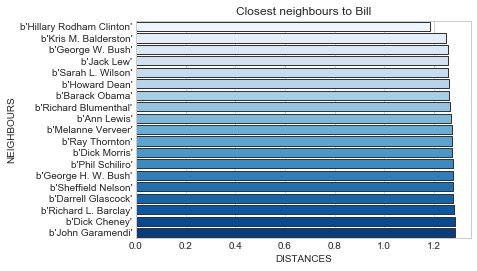

In [5]:
#Number of neighbors to use by default is 5 that's why we dont give to knn_neighbours any parameter
#weights: where  you detail if all points in each neighborhood are weighted equally or not.
#algorithm:‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute
#By default the distance that the algorithm uses is Mink
#and so on. For further information take a look at scikit
knn_neighbours = NearestNeighbors(n_neighbors=20)
knn_neighbours.fit(tfidf_matrix)
#closest_friends returns a list of lists. Where the first one belongs to the distances and the second one to the rows
closest_friends = knn_neighbours.kneighbors(tfidf_matrix.getrow(row), return_distance=True)
names_index = closest_friends[1][0]
names = [people_wiki_df.iloc[row]['name'].encode('utf-8') for row in names_index]
distances = closest_friends[0][0]
#If it is the case, we delete the name that has distance zero.
if distances[0]==0.0: distances,names = np.delete(distances,0),np.delete(names,0) 
data = pd.DataFrame({'Distances': distances,'Neighbours':names })
sns.set_style("whitegrid")
sns.set_context(rc = {'figure.figsize':(20,15)},font_scale=1.5)
closest_neighbours_to_bill = sns.barplot(x='Distances', y="Neighbours", data= data ,linewidth=1,edgecolor=".2",palette="Blues",saturation=1)
closest_neighbours_to_bill.set_title('Closest neighbours to Bill')
closest_neighbours_to_bill.set(xlabel='DISTANCES', ylabel='NEIGHBOURS')
plt.show()






### References
- [Scoring, term weighting and the vector space model](https://nlp.stanford.edu/IR-book/pdf/06vect.pdf)
- [Coursera tfidf and content filtering](https://www.coursera.org/learn/recommender-systems-introduction/lecture/I4aJD/tfidf-and-content-filtering)
- [MIT Artificial Intelligence](https://www.youtube.com/watch?v=4W4qxI2W00k&index=6&list=PLxymR0ZPfMmV-vGtvhvTeWHIcnh-bTjDI)
- [Elbow method](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)